## CIFAR-10 Dataset Classification using Nearest Class Mean (Euclidean)

### Summary
CIFAR-10 데이터셋을 분류하기 위해 NCM을 사용한다. 그리고 PCA를 이용하여 차원 축소 후 NCM을 이용하여 분류를 진행한다.

<span style="color: #2D3748; background-color:#fff5b1;">Test size를 0.2로 10번 반복 실험한 결과 평균적으로 0.34의 정확도를 보여주고 있고, test 데이터 1개를 분류하는데 0.0011초의 시간이 걸린다.</span>

<span style="color: #2D3748; background-color:#fff5b1;">Test size를 0.2로 PCA를 적용 후 10번 반복 실험한 결과 평균적으로 0.15의 정확도를 보여주고 있고, test 데이터 1개를 분류하는데 0.000002초의 시간이 걸린다.</span>

In [40]:
import time
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from utils import Info
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestCentroid
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader

In [41]:
class Config(Info):
    def __init__(self):
        super(Info, self).__init__()
        self.device = 'PC'
        self.dataset = 'CIFAR_10'
        self.test_size = 0.2
        self.feature_size = 3072
        self.method = 'NCM'
        self.distance = 'Euclidean'
        self.reduction_method = [None, None] # method, n_components
        self.iter = 10
    

In [42]:
cig = Config()
cig.info()
cig.print_rutin()

Device ── PC
│
├──Dataset
│    └────CIFAR_10
│    └────Train size 80%
│    └────Feature size: 3072
│
├──Method
│    └────NCM
│    └────Euclidean
│
├──Dimension reduction
│    └────Method: None
│    └────Component size: None
│    └────Feature Reduction Ratio: None%
│
└──Iteration
    └────10
PC - CIFAR_10(80%) - NCM - 10 iteration


## Load CIFAR-10 Dataset

In [43]:
transform = transforms.Compose([transforms.ToTensor()])

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

print(trainset.data.shape)
print(testset.data.shape)

Files already downloaded and verified
Files already downloaded and verified
(50000, 32, 32, 3)
(10000, 32, 32, 3)


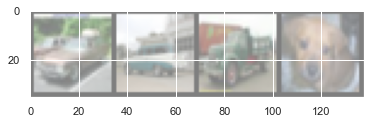

In [44]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(trainloader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images))

In [45]:
features = trainset.data.reshape(-1, cig.feature_size)
target = trainset.targets

features = features / 255.

print(np.array(features).shape)
print(np.array(target).shape)

(50000, 3072)
(50000,)


In [46]:
comparison_acc = []
comparison_pca_time = []
comparison_time = []

## Nearest Class Mean

In [47]:
avg_acc = []
avg_time = []

max_seed = cig.iter

for seed in range(max_seed):
    x_train, x_test, y_train, y_test = train_test_split(features, target, test_size=cig.test_size, random_state=seed, shuffle=True)

    nc = NearestCentroid()
    nc.fit(x_train, y_train)

    start = time.perf_counter()
    test_score = nc.score(x_test, y_test)
    end = time.perf_counter() - start

    avg_acc.append(test_score)
    avg_time.append(end)

mean_acc = np.array(avg_acc).mean()
mean_time = np.array(avg_time).mean()

comparison_acc.append(mean_acc)
comparison_time.append((mean_time / len(y_test)) * 1e6)

cig.print_rutin()
print("-----" * 8)
print("Test set score: %f" % mean_acc)
print("All Test dataset Prediction Average Time at once : %.4f" % mean_time, "sec")
print("Divide the Prediction Time by Test size : %f" % ((mean_time / len(y_test))*1e6), "ms")

PC - CIFAR_10(80%) - NCM - 10 iteration
----------------------------------------
Test set score: 0.271360
All Test dataset Prediction Average Time at once : 0.0991 sec
Divide the Prediction Time by Test size : 9.909739 ms


### kNN with PCA feature 3

In [48]:
cig.reduction_method = ['PCA', 3]
cig.info()

Device ── PC
│
├──Dataset
│    └────CIFAR_10
│    └────Train size 80%
│    └────Feature size: 3072
│
├──Method
│    └────NCM
│    └────Euclidean
│
├──Dimension reduction
│    └────Method: PCA
│    └────Component size: 3
│    └────Feature Reduction Ratio: 0.1%
│
└──Iteration
    └────10


In [49]:
avg_acc = []
avg_pca_time = []
avg_train_project_time = []
avg_test_project_time = []
avg_time = []

max_seed = cig.iter

for seed in range(max_seed):
    x_train, x_test, y_train, y_test = train_test_split(features, target, test_size=cig.test_size, random_state=seed, shuffle=True)

    pca = PCA(n_components=cig.reduction_method[1], random_state=seed)
    pca_start = time.perf_counter()
    pca.fit(x_train)
    pca_end = time.perf_counter() - pca_start
    avg_pca_time.append(pca_end)

    pca_p_start = time.perf_counter()
    x_train = pca.transform(x_train)
    pca_p_end = time.perf_counter() - pca_p_start
    avg_train_project_time.append(pca_p_end)

    nc = NearestCentroid()
    nc.fit(x_train, y_train)

    pca_p_start = time.perf_counter()
    x_test = pca.transform(x_test)
    pca_p_end = time.perf_counter() - pca_p_start
    avg_test_project_time.append(pca_p_end)

    start = time.perf_counter()
    test_score = nc.score(x_test, y_test)
    end = time.perf_counter() - start

    avg_acc.append(test_score)
    avg_time.append(end)

mean_pca_time = np.array(avg_pca_time).mean()
mean_train_project = np.array(avg_train_project_time).mean()
mean_test_project = np.array(avg_test_project_time).mean()

mean_acc = np.array(avg_acc).mean()
mean_time = np.array(avg_time).mean()

comparison_acc.append(mean_acc)
comparison_pca_time.append((mean_test_project / len(y_test)) * 1e6)
comparison_time.append((mean_time / len(y_test)) * 1e6)

cig.print_rutin()
print("-----" * 8)
print("The number of components: %d" % cig.reduction_method[1])
print("Calculating Train dataset U*S*Vt Matrix Time: %.4f" % mean_pca_time, "sec")
print("Calculating Train dataset Projection Time: %.4f" % mean_train_project, "sec")
print("Calculating Test dataset Projection Time: %.4f" % mean_test_project, "sec")
print("Calculating Test dataset Projection Time: %f" % ((mean_test_project / len(y_test))*1e6), "ms")
print("-----" * 8)
print("Test set score: %f" % mean_acc)
print("All Test dataset Prediction Average Time at once : %.4f" % mean_time, "sec")
print("Divide the Prediction Time by Test size : %f" % ((mean_time / len(y_test))*1e6), "ms")

PC - CIFAR_10(80%) - NCM - 10 iteration - PCA(feature 3)
----------------------------------------
The number of components: 3
Calculating Train dataset U*S*Vt Matrix Time: 3.5935 sec
Calculating Train dataset Projection Time: 0.5092 sec
Calculating Test dataset Projection Time: 0.1348 sec
Calculating Test dataset Projection Time: 13.483194 ms
----------------------------------------
Test set score: 0.228290
All Test dataset Prediction Average Time at once : 0.0036 sec
Divide the Prediction Time by Test size : 0.358501 ms


### kNN with PCA feature 2

In [50]:
cig.reduction_method = ['PCA', 2]
cig.info()

Device ── PC
│
├──Dataset
│    └────CIFAR_10
│    └────Train size 80%
│    └────Feature size: 3072
│
├──Method
│    └────NCM
│    └────Euclidean
│
├──Dimension reduction
│    └────Method: PCA
│    └────Component size: 2
│    └────Feature Reduction Ratio: 0.1%
│
└──Iteration
    └────10


In [51]:
avg_acc = []
avg_pca_time = []
avg_train_project_time = []
avg_test_project_time = []
avg_time = []

max_seed = cig.iter

for seed in range(max_seed):
    x_train, x_test, y_train, y_test = train_test_split(features, target, test_size=cig.test_size, random_state=seed, shuffle=True)

    pca = PCA(n_components=cig.reduction_method[1], random_state=seed)
    pca_start = time.perf_counter()
    pca.fit(x_train)
    pca_end = time.perf_counter() - pca_start
    avg_pca_time.append(pca_end)

    pca_p_start = time.perf_counter()
    x_train = pca.transform(x_train)
    pca_p_end = time.perf_counter() - pca_p_start
    avg_train_project_time.append(pca_p_end)

    nc = NearestCentroid()
    nc.fit(x_train, y_train)

    pca_p_start = time.perf_counter()
    x_test = pca.transform(x_test)
    pca_p_end = time.perf_counter() - pca_p_start
    avg_test_project_time.append(pca_p_end)

    start = time.perf_counter()
    test_score = nc.score(x_test, y_test)
    end = time.perf_counter() - start

    avg_acc.append(test_score)
    avg_time.append(end)

mean_pca_time = np.array(avg_pca_time).mean()
mean_train_project = np.array(avg_train_project_time).mean()
mean_test_project = np.array(avg_test_project_time).mean()

mean_acc = np.array(avg_acc).mean()
mean_time = np.array(avg_time).mean()

comparison_acc.append(mean_acc)
comparison_pca_time.append((mean_test_project / len(y_test))*1e6)
comparison_time.append((mean_time / len(y_test))*1e6)

cig.print_rutin()
print("-----" * 8)
print("The number of components: %d" % cig.reduction_method[1])
print("Calculating Train dataset U*S*Vt Matrix Time: %.4f" % mean_pca_time, "sec")
print("Calculating Train dataset Projection Time: %.4f" % mean_train_project, "sec")
print("Calculating Test dataset Projection Time: %.4f" % mean_test_project, "sec")
print("Calculating Test dataset Projection Time: %f" % ((mean_test_project / len(y_test))*1e6), "ms")
print("-----" * 8)
print("Test set score: %f" % mean_acc)
print("All Test dataset Prediction Average Time at once : %.4f" % mean_time, "sec")
print("Divide the Prediction Time by Test size : %f" % ((mean_time / len(y_test))*1e6), "ms")

PC - CIFAR_10(80%) - NCM - 10 iteration - PCA(feature 2)
----------------------------------------
The number of components: 2
Calculating Train dataset U*S*Vt Matrix Time: 3.4551 sec
Calculating Train dataset Projection Time: 0.4916 sec
Calculating Test dataset Projection Time: 0.1229 sec
Calculating Test dataset Projection Time: 12.294318 ms
----------------------------------------
Test set score: 0.200570
All Test dataset Prediction Average Time at once : 0.0030 sec
Divide the Prediction Time by Test size : 0.302996 ms


## Method Comparison

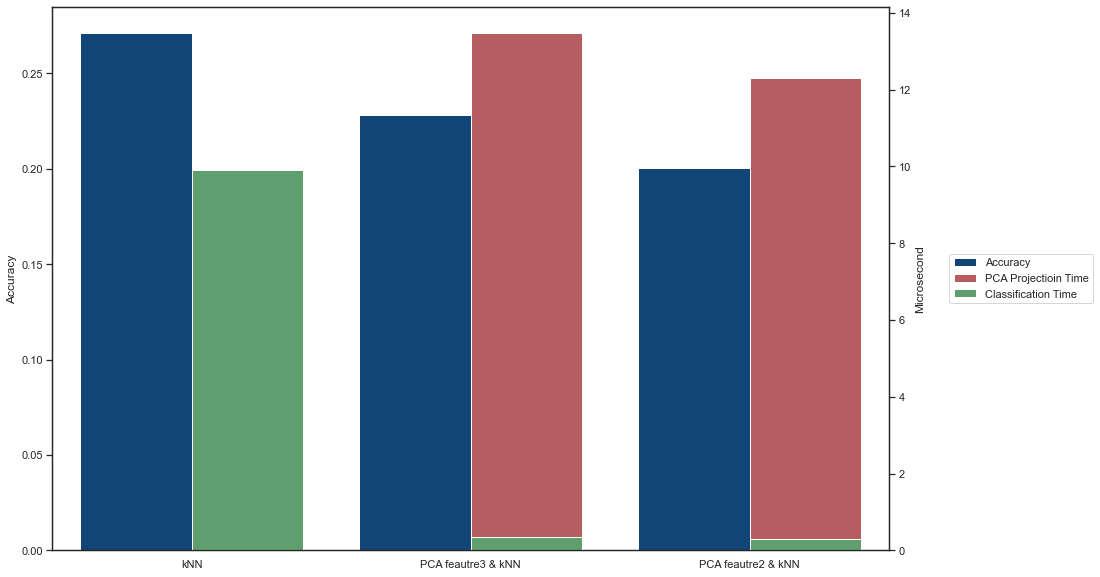

In [52]:
df_stack = pd.DataFrame(dict(
    score = [comparison_acc[0], comparison_acc[1], comparison_acc[2]],
    projection = [0, comparison_pca_time[0], comparison_pca_time[1]],
    classifier = [comparison_time[0], comparison_time[1], comparison_time[2]]
))

sns.set(style="white", rc={"lines.linewidth": 3})

fig, ax1 = plt.subplots(figsize=(15, 10))
ax2 = ax1.twinx()

sns.barplot(x=["kNN", "PCA feautre3 & kNN", "PCA feautre2 & kNN"],
            y="score",
            data=df_stack,
            label="Accuracy",
            color='#004488',
            ax=ax1)

sns.barplot(x=["kNN", "PCA feautre3 & kNN", "PCA feautre2 & kNN"], 
            y="projection",
            data=df_stack,
            label="PCA Projectioin Time",
            color='r',
            ax=ax2)

sns.barplot(x=["kNN", "PCA feautre3 & kNN", "PCA feautre2 & kNN"], 
            y="classifier",
            data=df_stack,
            label="Classification Time",
            color='g',
            ax=ax2)

ax1.set_ylabel("Accuracy")
ax2.set_ylabel("Microsecond")

lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()

lines = lines_1 + lines_2
labels = labels_1 + labels_2

width_scale = 0.5

for bar in ax1.containers[0]:
    bar.set_width(bar.get_width() * width_scale)

for bar_containers in ax2.containers:
    for bar in bar_containers:
        x = bar.get_x()
        w = bar.get_width()
        bar.set_x(x + w * (1- width_scale))
        bar.set_width(w * width_scale)

plt.legend(lines, labels, loc='center right', bbox_to_anchor=(1.25, 0.5))
plt.show()
sns.set()